In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from sklearn.preprocessing import MinMaxScaler

In [156]:
trump = pd.read_csv('trump_legacy/Trumps Legcy.csv')
stock = pd.read_csv('sp500_daily/sp500_stocks.csv')

In [157]:
trump['date'] = pd.to_datetime(trump['date'])
trump = trump.sort_values('date')

In [158]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

In [159]:
def is_only_link(text):
    text = text.strip()
    return text.startswith('http://') or text.startswith('https://') and ' ' not in text

# Remove rows where text is only a link
link_filtered = trump[~trump['text'].apply(is_only_link)]

In [160]:
# Remove rows where text is a retweet
retweet_filtered = link_filtered[~link_filtered['text'].str.startswith('RT')]

In [161]:
# Remove all links entirely
def remove_links(text):
    return ' '.join([word for word in text.split() if not is_only_link(word)])

trump['text'] = retweet_filtered['text'].apply(remove_links)
trump.dropna(subset=['text'], inplace=True)

In [162]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

vectorized_get_polarity = np.vectorize(get_polarity)

trump['polarity'] = vectorized_get_polarity(trump['text'])

In [163]:
trump['polarityCumulative'] = trump['polarity'].cumsum()

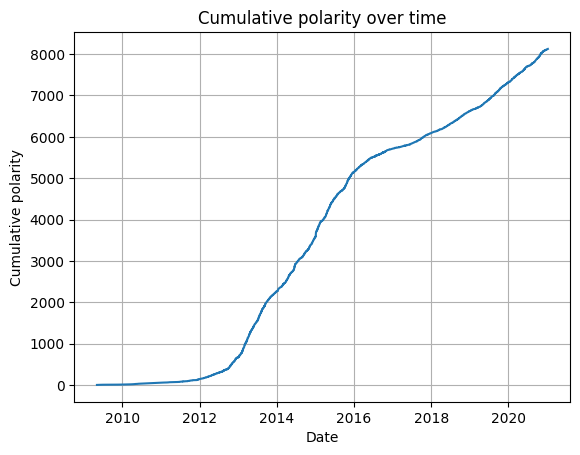

In [164]:
# Validating result is of similar trend to the EDA result
fig, ax = plt.subplots()
ax.plot(trump['date'], trump['polarityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative polarity',
       title='Cumulative polarity over time')
ax.grid()
plt.show()

In [176]:
correlations = {}
companies = stock['Symbol'].unique()

for company in companies:
    trump_2 = trump.copy()

    company_stock = stock[stock['Symbol'] == company]
    company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

    stock_min = company_stock[company_stock['Symbol'] == company]['Adj Close'].min()
    stock_max = company_stock[company_stock['Symbol'] == company]['Adj Close'].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
    trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

    company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]
    adj_close = company_stock['Adj Close'].dropna()
    polarity_scaled, adj_close = company_trump["polarityScaled"].align(adj_close, join='outer')
    polarity_scaled.ffill(inplace=True)
    adj_close.bfill(inplace=True)

    correlation = polarity_scaled.corr(adj_close, method='spearman') # Spearman correlation chosen due to non-linear relationship and resistent to outliers
    correlations[company] = correlation

In [179]:
correlations = pd.Series(correlations)
correlations = abs(correlations)
correlations = correlations.sort_values(ascending=False)
correlations.head(10)

ACN     0.556489
AOS     0.475536
HBAN    0.381600
IT      0.381600
MDLZ    0.381600
BWA     0.381600
ZION    0.381600
TSN     0.381600
LNT     0.381600
DPZ     0.381600
dtype: float64

C:\Users\hailea\AppData\Local\Temp\ipykernel_32580\1957414452.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  company_trump['polarityScaled'] = scaler.fit_transform(company_trump['polarityCumulative'].values.reshape(-1, 1))


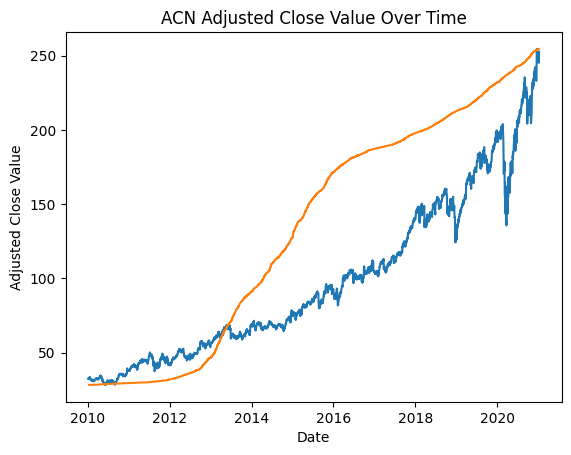

In [178]:
symbol = 'ACN'

company_stock = stock[stock['Symbol'] == symbol]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == symbol]['Adj Close'].min()
stock_max = company_stock[company_stock['Symbol'] == symbol]['Adj Close'].max()

company_trump = trump[trump['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]
scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
company_trump['polarityScaled'] = scaler.fit_transform(company_trump['polarityCumulative'].values.reshape(-1, 1))
plt.plot(company_stock['Date'], company_stock['Adj Close'])
plt.plot(company_trump['date'], company_trump['polarityScaled'])
plt.xlabel('Date')
plt.ylabel('Adjusted Close Value')
plt.title(symbol + ' Adjusted Close Value Over Time')
plt.show()